In [1]:
from enum import IntEnum
import time
import jsonrpclib
import subprocess
from subprocess import PIPE, Popen
from threading  import Thread
import sys
import re
from collections import OrderedDict
from logging import getLogger

import PySimpleGUI as sg

from gym import Env, error, spaces, utils
from stable_baselines3 import DQN, PPO, A2C, TD3, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.env_checker import check_env
import numpy as np

import os
import requests
import shutil
import tempfile
import xml.etree.ElementTree as ET
from io import StringIO, BytesIO

import cv2
import numpy as np
import torch
from PIL import Image
from cv2 import QRCodeDetector
from logging import getLogger

import olympe
from olympe.messages.ardrone3.Piloting import TakeOff, Landing, moveBy, PCMD, moveTo
from olympe.messages.ardrone3.PilotingState import FlyingStateChanged, PositionChanged, GpsLocationChanged, moveToChanged
from olympe.enums.ardrone3.PilotingState import FlyingStateChanged_State as FlyingState
from olympe.messages.ardrone3.GPSSettingsState import GPSFixStateChanged, HomeChanged
from olympe.messages.gimbal import set_target, attitude
from olympe.messages.camera import (
    set_camera_mode,
    set_photo_mode,
    take_photo,
    photo_progress,
)
from olympe.media import (
    media_created,
    resource_created,
    media_removed,
    resource_removed,
    resource_downloaded,
    indexing_state,
    delete_media,
    download_media,
    download_media_thumbnail,
    MediaEvent,
)
from olympe.messages.drone_manager import (
#     discover_drones,
    connection_state,
    connect,
#     forget,
)

from pynput.keyboard import Listener, Key, KeyCode
from collections import defaultdict

olympe.log.update_config({
    "loggers": {
        "olympe": {
                "handlers": []
            }
        },
        "ulog": {
            "level": "OFF",
            "handlers": [],
        }
})

In [2]:
logger = getLogger("photo_example")

DRONE_IP = os.environ.get("DRONE_IP", "10.202.0.1")
DRONE_MEDIA_PORT = os.environ.get("DRONE_MEDIA_PORT", "80")
DRONE_SSID = os.environ.get("DRONE_SSID", "Anafi_PC_000000")
DRONE_SECURITY_KEY = os.environ.get("DRONE_SECURITY_KEY", "")
DRONE_SERIAL = os.environ.get("DRONE_SERIAL", "000000")

img = None
def take_photo_single(drone, media):
    # take a photo single and get the associated media_id
    photo_saved = drone(photo_progress(result="photo_saved", _policy="wait"))
    drone(take_photo(cam_id=0)).wait()
    if not photo_saved.wait(_timeout=30).success():
        assert False, "take_photo timedout"
    photo_progress_info = photo_saved.received_events().last().args
    media_id = photo_progress_info["media_id"]
#     print("media_id", media_id)
    photo_count = photo_progress_info["photo_count"]
#     print("photo_count", photo_count)
    # download the photos associated with this media id
    drone.media.download_dir = tempfile.mkdtemp(prefix="olympe_photo_example")
    logger.info(
        "Download photo burst resources for media_id: {} in {}".format(
            media_id,
            drone.media.download_dir,
        )
    )
    media_download = drone(download_media(media_id, integrity_check=True))
#     print("media_download", media_download)
    
    resources = media_download.as_completed(expected_count=photo_count, timeout=60)
#     print("resources", resources)
    resource = next(resources)
#     print(resource.download_path)
#     print(drone.media.download_dir)
#     print(resource)
    with open(resource.download_path, "rb") as image_file:
        image_data = image_file.read()
#         print(type(image_file))
#         print(type(image_data))
        global img
        img = Image.open(BytesIO(image_data))
#         print(type(img))
#         display(img)
    assert media_download.wait(5).success(), "Photo burst media download"
    delete = delete_media(media_id, _timeout=10)
    assert media(delete).wait().success()
    
def setup_photo_burst_mode(drone):
    drone(set_camera_mode(cam_id=0, value="photo")).wait()

    assert drone(
        set_photo_mode(
            cam_id=0,
            mode="single",
            format= "rectilinear",
            file_format="jpeg",
            # the following are ignored in photo single mode
            burst="burst_14_over_1s",
            bracketing="preset_1ev",
            capture_interval=5.0,
        )
    ).wait().success()
    
    pitch = -90.0
    assert drone(
        set_target(
            gimbal_id=0,
            control_mode="position",
            yaw_frame_of_reference="none",
            yaw=0.0,
            pitch_frame_of_reference="absolute",
            pitch=pitch,
            roll_frame_of_reference="none",
            roll=0.0,
            )
        >> attitude(
            pitch_absolute=pitch, _policy="wait", _float_tol=(1e-3, 1e-1)
            )
        ).wait(_timeout=20).success()

def fly_and_detect():
    drone = olympe.Drone(DRONE_IP)
    drone.connect()
#     result = False
#     while not result:
#         print("connecting to the drone...")
#         drone.connect()
#         drone(TakeOff())
#         result = drone(
#             connect(serial=DRONE_SERIAL, key=DRONE_SECURITY_KEY)
#                 >> connection_state(state="connected", serial=DRONE_SERIAL)
#             ).wait(_timeout=10).success()
    
    assert drone(TakeOff()).wait().success()
    assert drone(moveBy(0, 0, -4, 0)).wait().success()
    
    assert drone.media_autoconnect
    media = drone.media
    media.integrity_check = True
    assert media(
        indexing_state(state="indexed")
    ).wait(_timeout=60).success()
    setup_photo_burst_mode(drone)
    take_photo_single(drone, media)
    
    assert drone(Landing()).wait().success()
    
    drone.disconnect()
    
def display_results():
    decoder = QRCodeDetector()
    img_arr = np.array(img)
    results = decoder.detectAndDecodeMulti(img_arr)

    _, values, _, _ = results

    print("Detected Targets")
    print("================")

    for value in values:
        print("Target", value)
    
    display(img)

In [6]:
fly_and_detect()

2022-02-03 14:53:18,731 [ERROR] 	ulog - arsdk - net Too many ping failures
2022-02-03 14:54:34,972 [ERROR] 	ulog - pomp - epoll_ctl(fd=136) err=9(Bad file descriptor)
2022-02-03 14:54:34,973 [ERROR] 	ulog - pomp - epoll_ctl op=2 cb=0x7f4573ec1cf8 userdata=0x7f44a41db590


Detected Targets
Target 4
Target 1
Target 2
Target 5


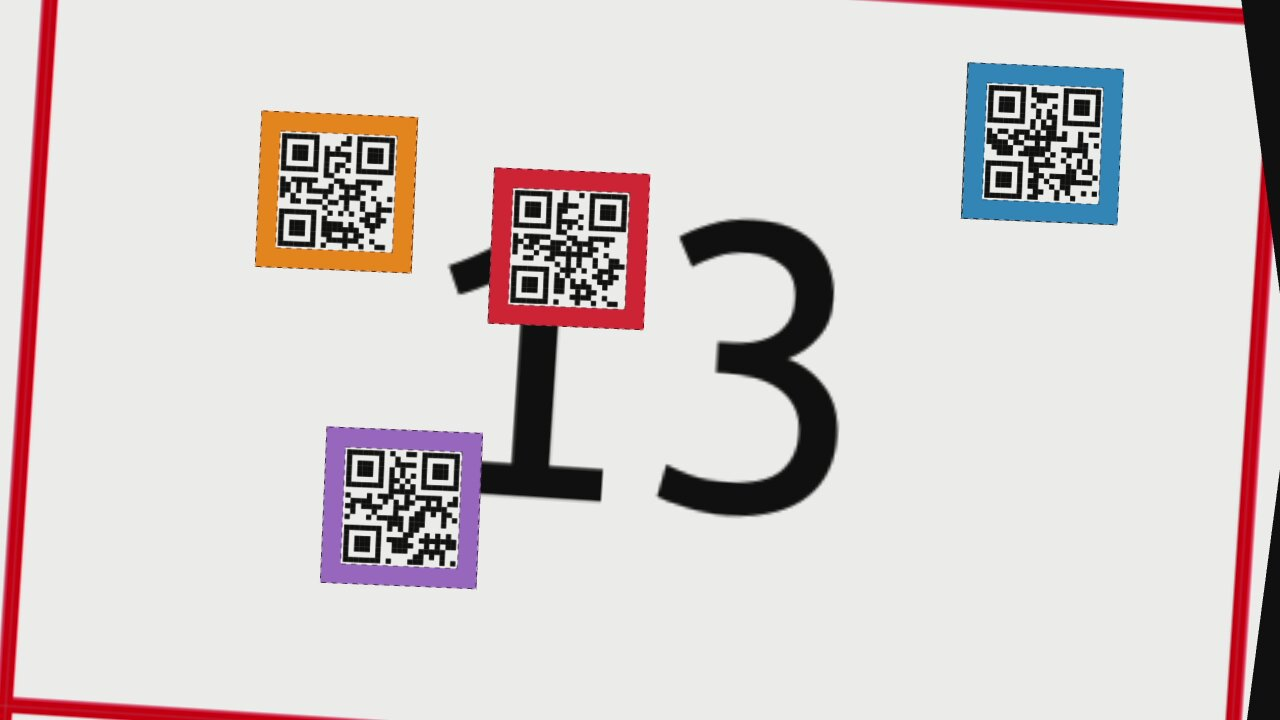

In [6]:
display_results()